#### Installs

In [5]:
!pip install bpemb

#### Imports

In [6]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import math
import functools as ft
import operator
from bpemb import BPEmb

from tqdm import tqdm

# Use GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


#### Data

In [10]:
# Load dataset
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('train_data.csv')

# divide data set
train_arab = train_df[train_df['language'] == 'arabic']
train_indo = train_df[train_df['language'] == 'indonesian']
train_beng = train_df[train_df['language'] == 'bengali']

val_arab = val_df[val_df['language'] == 'arabic']
val_indo = val_df[val_df['language'] == 'indonesian']
val_beng = val_df[val_df['language'] == 'bengali']

In [11]:
vocab_size = 10000
embedding_dim = 50

bpemb_en = BPEmb(lang="en", dim=embedding_dim, vs=vocab_size) # English (for testing)
bpemb_bn = BPEmb(lang="bn", dim=embedding_dim, vs=vocab_size) # Bengali
bpemb_ar = BPEmb(lang="ar", dim=embedding_dim, vs=vocab_size) # Arabic
bpemb_id = BPEmb(lang="id", dim=embedding_dim, vs=vocab_size) # Indonesian


embeddings_ar = bpemb_ar.emb.vectors
embeddings_bn = bpemb_bn.emb.vectors
embeddings_id = bpemb_id.emb.vectors

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.model


100%|██████████| 400869/400869 [00:00<00:00, 734715.89B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1924908/1924908 [00:00<00:00, 2828009.13B/s]


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs10000.model


100%|██████████| 471203/471203 [00:00<00:00, 1053434.02B/s]


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1933584/1933584 [00:00<00:00, 2489166.84B/s]


downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs10000.model


100%|██████████| 428120/428120 [00:00<00:00, 953816.50B/s]


downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1928527/1928527 [00:00<00:00, 2848987.60B/s]


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs10000.model


100%|██████████| 396303/396303 [00:00<00:00, 880045.18B/s]


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1920574/1920574 [00:00<00:00, 2822384.21B/s]


#### Data loader

In [12]:
def get_batch(data, seq_len, num_batches, idx):
    """
    given the index of the first batch of tokens in the batch returns the
    corresponding batch of sequences.

    data: in [batch size, num_batches] format
    seq_len: length of sequence
    idx: index

    returns: input and targets of the LSTM
    """
    src = data[:, idx:idx+seq_len]        #
    target = data[:, idx+1:idx+seq_len+1] # next words
    return src, target

# define dataloader
def get_data(dataset: list, vocab, batch_size):
    """
    dataset: pandas series
    vocab: bpemb entity
    batch_size: size of batch
    """
    encoded = vocab.encode_ids_with_bos_eos(dataset.values)
    flat = ft.reduce(operator.iconcat, encoded, [])
    data = torch.tensor(flat)
    num_batches = data.shape[0] // batch_size
    data = data[:num_batches * batch_size] # remove modulus (leftovers)
    data = data.view(batch_size, num_batches)
    return data


#### Define model

In [13]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, hidden_dim: int, lstm_layers: int,
                 dropout_rate: float, tie_weights: bool, vocab):

        super().__init__()
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab.vectors.shape[0]
        self.embedding_dim = vocab.vectors.shape[1]
        self.num_layers = lstm_layers

        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(torch.tensor(vocab.vectors)),
            'lstm': nn.LSTM(
                self.embedding_dim,
                hidden_dim,
                lstm_layers,
                batch_first=True,
                dropout=dropout_rate,
                bidirectional=False),
            'fc': nn.Linear(hidden_dim, vocab_size)
        })
        self.dropout = nn.Dropout(p=dropout_rate)

        if tie_weights:
            assert embedding_dim == hidden_dim, 'cannot tie, check dims'
            self.embedding.weight = self.fc.weight

        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['lstm'].named_parameters()) + \
                     list(self.model['fc'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell

    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()
        return hidden, cell

    def forward(self, src, hidden):
        embeds = self.model['embeddings'](src)
        lstm_out, hidden = self.model['lstm'](embeds)
        fc_in = self.dropout(lstm_out)
        logits = self.model['fc'](fc_in)

        return logits, hidden

#### Define training

In [14]:
# Train loop
def train(model, data, optimizer, criterion, batch_size, seq_len, clip, device):

    epoch_loss = 0
    model.train() # training mode - dropout not disabled
    # drop all batches that are not a multiple of seq_len
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    # The last batch can't be a src
    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):
        optimizer.zero_grad()
        hidden = model.detach_hidden(hidden)

        src, target = get_batch(data, seq_len, num_batches, idx)
        src, target = src.to(device), target.to(device)
        batch_size = src.shape[0]
        prediction, hidden = model(src, hidden)
        prediction = prediction.reshape(batch_size * seq_len, -1)
        target = target.reshape(-1)
        loss = criterion(prediction, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * seq_len
    return epoch_loss / num_batches



#### Define evaluation

In [15]:
def evaluate(model, data, criterion, batch_size, seq_len, device):

    model.eval()
    eval_loss = 0

    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad(): # we no longer need to backprop or keep track of gradients.
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, num_batches, idx)
            src, target = src.to(device), target.to(device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            eval_loss += loss.item() * seq_len
    return eval_loss / num_batches

#### Hyperparameters

In [16]:
# Model
num_layers = 2
dropout_rate = 0.1
hidden_dim = 128
tie_weights = True if embedding_dim == hidden_dim else False

# Training
lr = 1e-3
batch_size = 64
n_epochs = 10
seq_len = 10
clip = 0.25

saved = False

#### Train

##### Just one

In [34]:
ln = 'arab'
doc = 'question_text'
vocab = bpemb_ar

train_data = get_data(train_arab[doc], vocab, batch_size)
val_data = get_data(val_arab[doc], vocab, batch_size)

model = LSTM(hidden_dim, num_layers, dropout_rate, tie_weights, vocab).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# reduce learning rate as we go along
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

best_valid_loss = float('inf')

for epoch in range(n_epochs):

    train_loss = train(model, train_data, optimizer, criterion,
                batch_size, seq_len, clip, device)
    valid_loss = evaluate(model, val_data, criterion, batch_size,
                seq_len, device)

    lr_scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        name = 'best-val-'+ln+'-'+doc+'.pt'
        torch.save(model.state_dict(), name)

    print(f'Epoch: {epoch+1}')
    print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
    print(f'\tValid Perplexity: {math.exp(valid_loss):.3f}')

valid_loss = evaluate(model, train_data, criterion, batch_size,
                seq_len, device)
print(f'\tFinal train Perplexity: {math.exp(valid_loss):.3f}')



Epoch: 1
	Train Perplexity: 548.751
	Valid Perplexity: 298.709


Epoch: 2
	Train Perplexity: 135.745
	Valid Perplexity: 90.718


Epoch: 3
	Train Perplexity: 77.664
	Valid Perplexity: 60.403


Epoch: 4
	Train Perplexity: 56.159
	Valid Perplexity: 45.857


Epoch: 5
	Train Perplexity: 44.825
	Valid Perplexity: 37.479


Epoch: 6
	Train Perplexity: 37.729
	Valid Perplexity: 32.018


Epoch: 7
	Train Perplexity: 32.864
	Valid Perplexity: 28.155


Epoch: 8
	Train Perplexity: 29.320
	Valid Perplexity: 25.234


Epoch: 9
	Train Perplexity: 26.526
	Valid Perplexity: 22.898


Epoch: 10
	Train Perplexity: 24.277
	Valid Perplexity: 20.977
	Final train Perplexity: 20.977


#### Train all

In [17]:
print(device)
lang = [(bpemb_ar, train_arab, val_arab, 'arab'),
        (bpemb_bn, train_beng, val_beng, 'beng'),
        (bpemb_id, train_indo, val_indo, 'indo')]

# Train and validate all 6 models
for vocab, train_df, val_df, ln in lang:
    print(f'Lanuage: {ln}')
    for doc in ['question_text', 'document_plaintext']:
        print(f'Data: {doc}')

        train_data = get_data(train_df[doc], vocab, batch_size)
        val_data = get_data(val_df[doc], vocab, batch_size)

        model = LSTM(hidden_dim, num_layers, dropout_rate, tie_weights, vocab).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()


        # reduce learning rate as we go along
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

        if saved:
            model.load_state_dict(torch.load('best-val-lstm_lm.pt',  map_location=device))
            test_loss = evaluate(model, val_data, criterion, batch_size, seq_len, device)
            print(f'Test Perplexity: {math.exp(test_loss):.3f}')
        else:
            best_valid_loss = float('inf')

            for epoch in range(n_epochs):

                train_loss = train(model, train_data, optimizer, criterion,
                            batch_size, seq_len, clip, device)
                valid_loss = evaluate(model, val_data, criterion, batch_size,
                            seq_len, device)

                lr_scheduler.step(valid_loss)

                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    name = 'best-val-'+ln+'-'+doc+'.pt'
                    torch.save(model.state_dict(), name)

                print(f'Epoch: {epoch+1}')
                print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
                print(f'\tValid Perplexity: {math.exp(valid_loss):.3f}')

            valid_loss = evaluate(model, train_data, criterion, batch_size,
                            seq_len, device)
            print(f'\tFinal train Perplexity: {math.exp(valid_loss):.3f}')



cuda
Lanuage: arab
Data: question_text


Epoch: 1
	Train Perplexity: 523.842
	Valid Perplexity: 234.629


Epoch: 2
	Train Perplexity: 126.945
	Valid Perplexity: 88.639


Epoch: 3
	Train Perplexity: 76.541
	Valid Perplexity: 59.989


Epoch: 4
	Train Perplexity: 55.900
	Valid Perplexity: 45.586


Epoch: 5
	Train Perplexity: 44.717
	Valid Perplexity: 37.356


Epoch: 6
	Train Perplexity: 37.776
	Valid Perplexity: 31.982


Epoch: 7
	Train Perplexity: 32.986
	Valid Perplexity: 28.134


Epoch: 8
	Train Perplexity: 29.440
	Valid Perplexity: 25.227


Epoch: 9
	Train Perplexity: 26.664
	Valid Perplexity: 22.962


Epoch: 10
	Train Perplexity: 24.427
	Valid Perplexity: 21.093
	Final train Perplexity: 21.093
Data: document_plaintext


Epoch: 1
	Train Perplexity: 692.741
	Valid Perplexity: 394.302


Epoch: 2
	Train Perplexity: 362.856
	Valid Perplexity: 288.728


Epoch: 3
	Train Perplexity: 299.675
	Valid Perplexity: 245.869


Epoch: 4
	Train Perplexity: 269.542
	Valid Perplexity: 222.321


Epoch: 5
	Train Perplexity: 251.610
	Valid Perplexity: 207.185


Epoch: 6
	Train Perplexity: 239.657
	Valid Perplexity: 196.380


Epoch: 7
	Train Perplexity: 231.189
	Valid Perplexity: 188.626


Epoch: 8
	Train Perplexity: 224.515
	Valid Perplexity: 182.706


Epoch: 9
	Train Perplexity: 219.442
	Valid Perplexity: 177.842


Epoch: 10
	Train Perplexity: 215.232
	Valid Perplexity: 173.845
	Final train Perplexity: 173.845
Lanuage: beng
Data: question_text


Epoch: 1
	Train Perplexity: 1097.446
	Valid Perplexity: 451.146


Epoch: 2
	Train Perplexity: 449.890
	Valid Perplexity: 383.585


Epoch: 3
	Train Perplexity: 364.056
	Valid Perplexity: 267.036


Epoch: 4
	Train Perplexity: 224.832
	Valid Perplexity: 171.600


Epoch: 5
	Train Perplexity: 160.591
	Valid Perplexity: 135.284


Epoch: 6
	Train Perplexity: 132.136
	Valid Perplexity: 114.279


Epoch: 7
	Train Perplexity: 111.876
	Valid Perplexity: 96.089


Epoch: 8
	Train Perplexity: 94.746
	Valid Perplexity: 80.732


Epoch: 9
	Train Perplexity: 79.461
	Valid Perplexity: 67.125


Epoch: 10
	Train Perplexity: 66.883
	Valid Perplexity: 56.919
	Final train Perplexity: 56.919
Data: document_plaintext


Epoch: 1
	Train Perplexity: 1453.807
	Valid Perplexity: 876.748


Epoch: 2
	Train Perplexity: 724.455
	Valid Perplexity: 554.634


Epoch: 3
	Train Perplexity: 510.862
	Valid Perplexity: 410.759


Epoch: 4
	Train Perplexity: 403.460
	Valid Perplexity: 327.962


Epoch: 5
	Train Perplexity: 336.264
	Valid Perplexity: 273.560


Epoch: 6
	Train Perplexity: 290.394
	Valid Perplexity: 235.749


Epoch: 7
	Train Perplexity: 257.330
	Valid Perplexity: 207.802


Epoch: 8
	Train Perplexity: 232.474
	Valid Perplexity: 186.812


Epoch: 9
	Train Perplexity: 213.193
	Valid Perplexity: 169.730


Epoch: 10
	Train Perplexity: 197.625
	Valid Perplexity: 156.733
	Final train Perplexity: 156.733
Lanuage: indo
Data: question_text


Epoch: 1
	Train Perplexity: 575.581
	Valid Perplexity: 316.155


Epoch: 2
	Train Perplexity: 317.546
	Valid Perplexity: 294.255


Epoch: 3
	Train Perplexity: 299.191
	Valid Perplexity: 266.432


Epoch: 4
	Train Perplexity: 151.793
	Valid Perplexity: 89.826


Epoch: 5
	Train Perplexity: 74.988
	Valid Perplexity: 57.968


Epoch: 6
	Train Perplexity: 53.331
	Valid Perplexity: 44.379


Epoch: 7
	Train Perplexity: 43.318
	Valid Perplexity: 37.198


Epoch: 8
	Train Perplexity: 37.023
	Valid Perplexity: 32.091


Epoch: 9
	Train Perplexity: 32.315
	Valid Perplexity: 28.133


Epoch: 10
	Train Perplexity: 28.657
	Valid Perplexity: 25.022
	Final train Perplexity: 25.022
Data: document_plaintext


Epoch: 1
	Train Perplexity: 1307.539
	Valid Perplexity: 744.935


Epoch: 2
	Train Perplexity: 550.682
	Valid Perplexity: 406.256


Epoch: 3
	Train Perplexity: 376.683
	Valid Perplexity: 305.684


Epoch: 4
	Train Perplexity: 306.314
	Valid Perplexity: 253.660


Epoch: 5
	Train Perplexity: 265.521
	Valid Perplexity: 220.215


Epoch: 6
	Train Perplexity: 238.332
	Valid Perplexity: 197.202


Epoch: 7
	Train Perplexity: 218.854
	Valid Perplexity: 180.273


Epoch: 8
	Train Perplexity: 204.271
	Valid Perplexity: 167.475


Epoch: 9
	Train Perplexity: 192.968
	Valid Perplexity: 157.466


Epoch: 10
	Train Perplexity: 183.972
	Valid Perplexity: 149.079
	Final train Perplexity: 149.079


#### Next word generation

Evaluate next word genertaion, with top-k predictions.

```
For document/question in validation data set:
    Based on <bos> token(s), guess first token/word
    check "correctness" of prediction
    for word/token in document/questios:
        Based all previous words/tokens, guess the next word/token
        check "correctness"

Afterwards find accuracy of 1st word predictions, 2nd word predictions and so on.
Limit this to e.g. 10 words/tokens.
OBS: Some sentences might be shorter that 10 words/tokens

"Correctness": Prediction is considered correct if either of top-k most likely words/tokens is correct.

```



In [18]:
def eval_word_gen(model, data, bpemb, doc, k, max_len):
    hidden = model.init_hidden(batch_size, device)

    # results for each row in the dataframe gets collected here
    row_results = []
    for row in tqdm(data[doc], desc='Evaluating: '):

        # data encoded as ids
        sentence = bpemb.encode_ids_with_bos_eos(row)

        # Collects resutls. Will be a list of True/False values
        word_results = []

        # Be careful of sentences shorter than max_len
        for i in range(1, min(max_len+1, len(sentence))):
            src = torch.LongTensor([sentence[:i]]).to(device)

            # prediction
            preds, _ = model(src, hidden)

            pred = preds[:,-1]

            # get as probabilities (not necessary, unless we want to sample the answer from a multinomial)
            pred = torch.softmax(pred, dim=1)

            # find index of top k predictions
            _, ids = torch.topk(pred, k)

            # if the true index is in the list of top k predictions, we count it as correct
            word_results.append(sentence[i] in ids)
        row_results.append(word_results)
    return row_results

def compute_performance(results, max_len):
    # not all lists are necessarily max_len
    correct = torch.zeros(max_len)
    counter = torch.zeros(max_len)
    for res in results:
        for i, val in enumerate(res):
            # Count correct for each index
            correct[i] += val
            counter[i] += 1
    return correct / counter



In [19]:
k=3
max_len=10

lang = [(bpemb_ar, val_arab, 'arab'),
        (bpemb_bn, val_beng, 'beng'),
        (bpemb_id, val_indo, 'indo')]

# Evaluate all 6 models
accuracies = []
for vocab, val_df, ln in lang:
    print(f'Lanuage: {ln}')
    for doc in ['question_text', 'document_plaintext']:


        print(f'Data: {doc}')
        name = 'best-val-'+ln+'-'+doc+'.pt'
        model.load_state_dict(torch.load(name,  map_location=device))

        results = eval_word_gen(model, val_df, vocab, doc, k, max_len)
        acc = compute_performance(results,max_len)
        identifier = ln + ' ' + doc
        print(acc)
        accuracies.append((identifier, acc))

print('\n', accuracies)

Lanuage: arab
Data: question_text


Evaluating: 100%|██████████| 29598/29598 [03:13<00:00, 152.98it/s]


tensor([0.7442, 0.8421, 0.3237, 0.2979, 0.3041, 0.3818, 0.4844, 0.5610, 0.5969,
        0.6299])
Data: document_plaintext


Evaluating: 100%|██████████| 29598/29598 [03:53<00:00, 126.53it/s]


tensor([0.3480, 0.4675, 0.2336, 0.2682, 0.2619, 0.2709, 0.2849, 0.2964, 0.2979,
        0.3050])
Lanuage: beng
Data: question_text


Evaluating: 100%|██████████| 4779/4779 [00:35<00:00, 135.62it/s]


tensor([0.0778, 0.0829, 0.0785, 0.1408, 0.2316, 0.3254, 0.4327, 0.5014, 0.5624,
        0.6040])
Data: document_plaintext


Evaluating: 100%|██████████| 4779/4779 [00:35<00:00, 135.50it/s]


tensor([0.2404, 0.4133, 0.2724, 0.2716, 0.2708, 0.2733, 0.2749, 0.2892, 0.2850,
        0.2836])
Lanuage: indo
Data: question_text


Evaluating: 100%|██████████| 11394/11394 [01:15<00:00, 150.98it/s]


tensor([0.5113, 0.7460, 0.4867, 0.3236, 0.2186, 0.3368, 0.4809, 0.5877, 0.6496,
        0.6802])
Data: document_plaintext


Evaluating: 100%|██████████| 11394/11394 [01:30<00:00, 126.37it/s]


tensor([0.2145, 0.3884, 0.2759, 0.2956, 0.2904, 0.2926, 0.3173, 0.3105, 0.3188,
        0.3036])

 [('arab question_text', tensor([0.7442, 0.8421, 0.3237, 0.2979, 0.3041, 0.3818, 0.4844, 0.5610, 0.5969,
        0.6299])), ('arab document_plaintext', tensor([0.3480, 0.4675, 0.2336, 0.2682, 0.2619, 0.2709, 0.2849, 0.2964, 0.2979,
        0.3050])), ('beng question_text', tensor([0.0778, 0.0829, 0.0785, 0.1408, 0.2316, 0.3254, 0.4327, 0.5014, 0.5624,
        0.6040])), ('beng document_plaintext', tensor([0.2404, 0.4133, 0.2724, 0.2716, 0.2708, 0.2733, 0.2749, 0.2892, 0.2850,
        0.2836])), ('indo question_text', tensor([0.5113, 0.7460, 0.4867, 0.3236, 0.2186, 0.3368, 0.4809, 0.5877, 0.6496,
        0.6802])), ('indo document_plaintext', tensor([0.2145, 0.3884, 0.2759, 0.2956, 0.2904, 0.2926, 0.3173, 0.3105, 0.3188,
        0.3036]))]


Plot accuracies

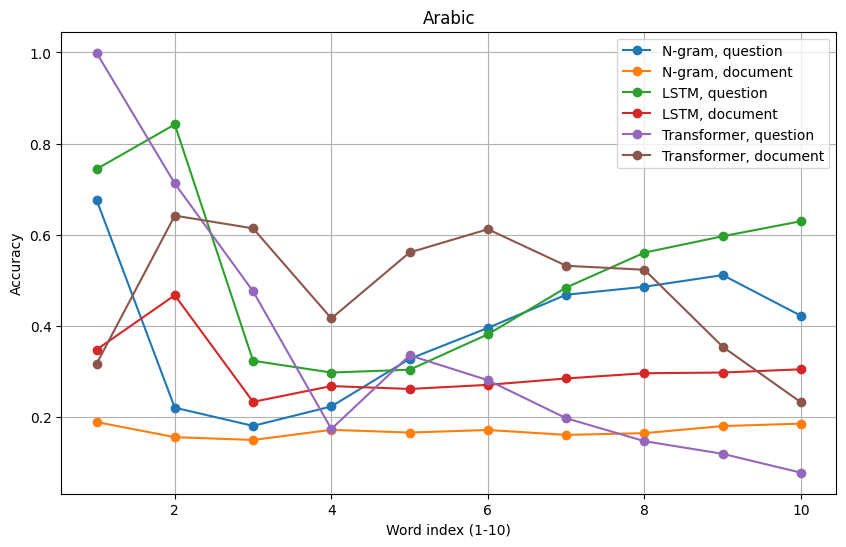

In [3]:
import matplotlib.pyplot as plt

model_names = ['N-gram, question',
               'N-gram, document',
               'LSTM, question',
               'LSTM, document',
               'Transformer, question',
               'Transformer, document']
accuracy_data = [
    [0.6771819137749737, 0.22082018927444794, 0.1808622502628812, 0.2235817575083426, 0.3278955954323002, 0.3958333333333333, 0.4686192468619247, 0.4861111111111111, 0.5116279069767442, 0.4222222222222222],  # Ngram quest
    [0.1892744479495268, 0.15615141955835962, 0.15, 0.17223105458399576, 0.16622127204703366, 0.17189189189189188, 0.16111414527580556, 0.16501103752759383, 0.18050139275766017, 0.1858108108108108],  # Ngram docs
    [0.7442, 0.8421, 0.3237, 0.2979, 0.3041, 0.3818, 0.4844, 0.5610, 0.5969, 0.6299],  # LSTM quest
    [0.3480, 0.4675, 0.2336, 0.2682, 0.2619, 0.2709, 0.2849, 0.2964, 0.2979, 0.3050],  # LSTM docs
    [0.9994756161510225, 0.7126376507603566, 0.47614053487152597, 0.1740954378605139, 0.33560566334556896, 0.281069743051914, 0.1976927110644992, 0.14735186156266386, 0.11955951756685894, 0.07813319349764027],   # Trans quest
    [0.3166, 0.6421, 0.6142, 0.4166, 0.5613, 0.6123, 0.5321, 0.5234, 0.3543, 0.2324] # TRANS DOC
    ]

# Create x-values (numbers 1 to 10)
x_values = list(range(1, 11))

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
for i in range(len(model_names)):
    plt.plot(x_values, accuracy_data[i], marker='o', label=model_names[i])

plt.title("Arabic")
plt.xlabel("Word index (1-10)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc='best')

# Show the plot
plt.show()


Bengali

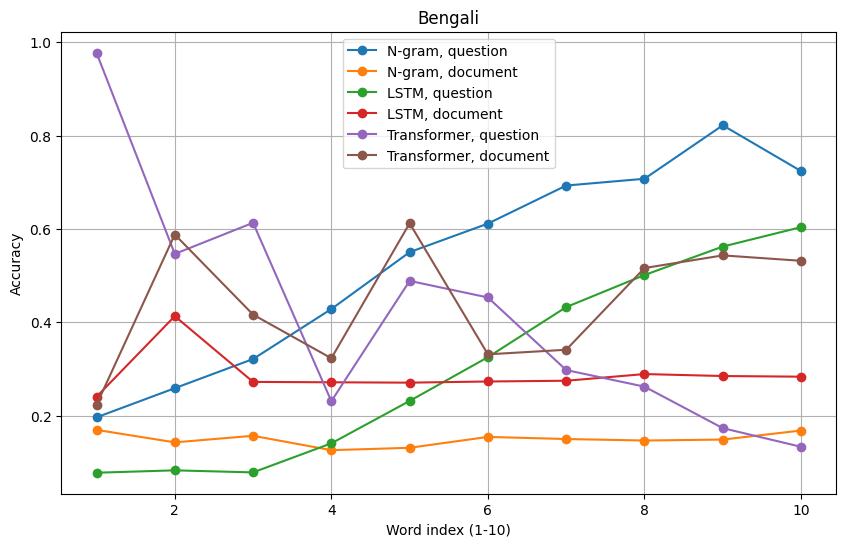

In [4]:
import matplotlib.pyplot as plt

model_names = ['N-gram, question',
               'N-gram, document',
               'LSTM, question',
               'LSTM, document',
               'Transformer, question',
               'Transformer, document']
accuracy_data = [
    [0.19642857142857142, 0.25892857142857145, 0.32142857142857145, 0.42857142857142855, 0.5504587155963303, 0.6116504854368932, 0.6931818181818182, 0.7076923076923077, 0.8222222222222222, 0.7241379310344828], # Ngram quest
    [0.16964285714285715, 0.14285714285714285, 0.15695067264573992, 0.12612612612612611, 0.13122171945701358, 0.15454545454545454, 0.15, 0.14678899082568808, 0.14883720930232558, 0.16822429906542055], # Ngram docs
    [0.0778, 0.0829, 0.0785, 0.1408, 0.2316, 0.3254, 0.4327, 0.5014, 0.5624, 0.6040],  # LSTM quest
    [0.2404, 0.4133, 0.2724, 0.2716, 0.2708, 0.2733, 0.2749, 0.2892, 0.2850, 0.2836],  # LSTM docs
    [0.9777777777777777, 0.5466666666666666, 0.6133333333333333, 0.2311111111111111, 0.4888888888888889, 0.4533333333333333, 0.29777777777777775, 0.26222222222222225, 0.17333333333333334, 0.13333333333333333], # Trans quest
    [0.2234, 0.5882, 0.4166, 0.3231, 0.6123, 0.3315, 0.3413, 0.5164, 0.5435, 0.5319] # Trans doc
    ]

# Create x-values (numbers 1 to 10)
x_values = list(range(1, 11))

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
for i in range(len(model_names)):
    plt.plot(x_values, accuracy_data[i], marker='o', label=model_names[i])

plt.title("Bengali")
plt.xlabel("Word index (1-10)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc='best')

# Show the plot
plt.show()

Indonesis

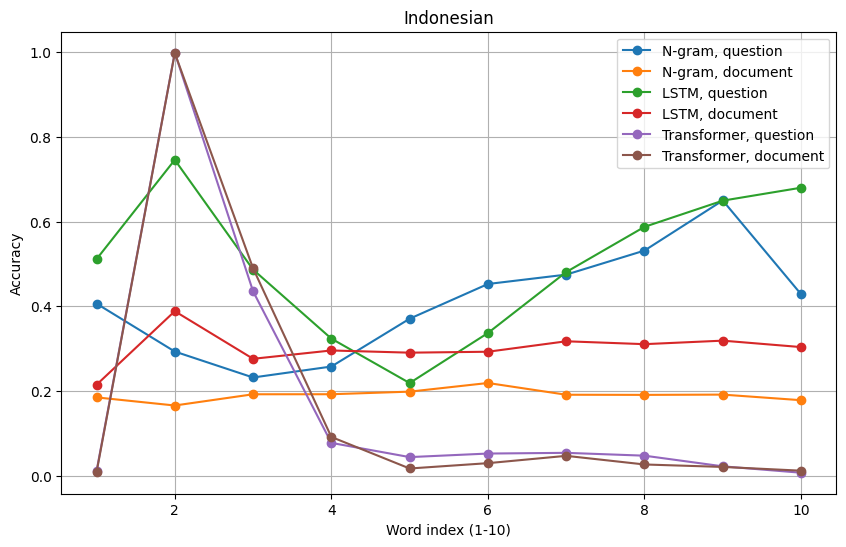

In [6]:
import matplotlib.pyplot as plt

model_names = ['N-gram, question',
               'N-gram, document',
               'LSTM, question',
               'LSTM, document',
               'Transformer, question',
               'Transformer, document']
accuracy_data = [
    [0.4063811922753988, 0.29303106633081444, 0.23173803526448364, 0.2576419213973799, 0.3706140350877193, 0.45266781411359724, 0.4748201438848921, 0.5316455696202531, 0.65, 0.42857142857142855], # Ngram quest
    [0.1847187237615449, 0.16554621848739495, 0.19208087615838249, 0.1921768707482993, 0.1982832618025751, 0.21872265966754156, 0.1909814323607427, 0.1906474820143885, 0.1912964641885766, 0.1780821917808219], # Ngram docs
    [0.5113, 0.7460, 0.4867, 0.3236, 0.2186, 0.3368, 0.4809, 0.5877, 0.6496, 0.6802],  # LSTM quest
    [0.2145, 0.3884, 0.2759, 0.2956, 0.2904, 0.2926, 0.3173, 0.3105, 0.3188, 0.3036],  # LSTM docs
    [0.010067114093959731, 0.9991610738255033, 0.4354026845637584, 0.07718120805369127, 0.0436241610738255, 0.05201342281879195, 0.053691275167785234, 0.04697986577181208, 0.02181208053691275, 0.006711409395973154], # Trans quest
    [0.0073, 0.9984, 0.4897, 0.0912, 0.0167, 0.0293, 0.0466, 0.0262, 0.0204, 0.01153] # Trans doc
    ]

# Create x-values (numbers 1 to 10)
x_values = list(range(1, 11))

# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size
for i in range(len(model_names)):
    plt.plot(x_values, accuracy_data[i], marker='o', label=model_names[i])

plt.title("Indonesian")
plt.xlabel("Word index (1-10)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc='best')

# Show the plot
plt.show()